In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures

# 线性模型在非线性数据上的表现

In [2]:
rnd = np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)

In [3]:
y = np.sin(X) + rnd.normal(size=len(X)) / 3

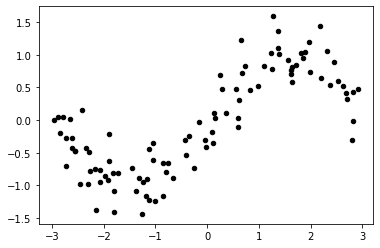

In [4]:
plt.scatter(X, y, marker="o", c="k", s=20)
plt.show()

In [5]:
print(X.shape)
print(y.shape)
print(type(LR()))

(100,)
(100,)
<class 'sklearn.linear_model._base.LinearRegression'>


In [6]:
# 输入 fit 的需要是二维
X = X.reshape(-1, 1)

LinearR = LR().fit(X, y)
TreeR = DecisionTreeRegressor(random_state=0).fit(X, y)

## 数据拟合图像

Text(0.5, 0, 'input feature')

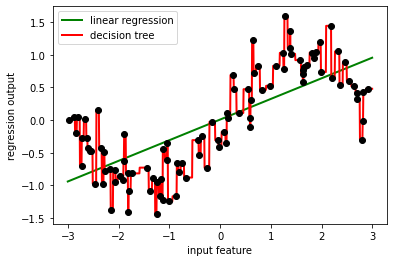

In [7]:
# 放置画布，需要和画图在一个 cell 里
fig, ax1 = plt.subplots(1)

# 创建测试数据: 一系列分布在横坐标上的点

line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# 将测试数据代入 predict 接口，获得模型的拟合效果进行绘制
ax1.plot(line, LinearR.predict(line)
         ,linewidth=2
         ,color="green"
         ,label="linear regression"
        )
ax1.plot(line, TreeR.predict(line)
         ,linewidth=2
         ,color="red"
         ,label="decision tree"
        )

# 将元数据上的拟合绘制在图像上
ax1.plot(X[:, 0], y, "o", c="k")

ax1.legend(loc="best")
ax1.set_ylabel("regression output")
ax1.set_xlabel("input feature")

# 分箱处理非线性数据

In [8]:
enc = KBinsDiscretizer(n_bins=10
                       ,encode="onehot"
                      )
X_binned = enc.fit_transform(X)

In [9]:
X.shape

(100, 1)

In [10]:
X_binned

<100x10 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [11]:
# 用 pandas 打开稀疏矩阵

pd.DataFrame(X_binned.toarray()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
LinearR_ = LR().fit(X_binned, y)

## 测试集 line 也要相同地分箱
- enc 也是要持久化之后部署的

In [13]:
line_binned = enc.transform(line)

In [14]:
LinearR_.predict(line_binned).shape

(1000,)

In [15]:
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)

## 拟合图像对比

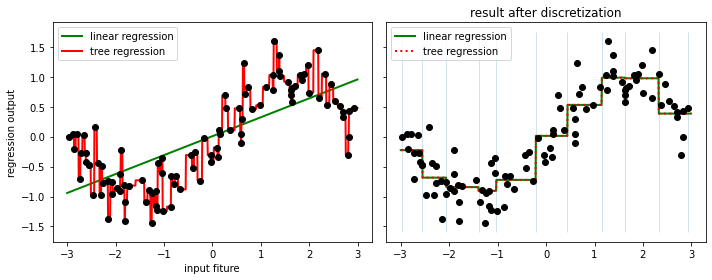

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2
                               ,sharey=True # 两种图共享 y 轴刻度
                               ,figsize=(10, 4)
                              )

ax1.plot(line, LinearR.predict(line)
         ,linewidth=2
         ,color="green"
         ,label="linear regression"
        )
ax1.plot(line, TreeR.predict(line)
         ,linewidth=2
         ,color="red"
         ,label="tree regression"
        )
ax1.plot(X[:, 0], y, "o", c="k")
ax1.legend(loc="best")
ax1.set_xlabel("input fiture")
ax1.set_ylabel("regression output")

ax2.plot(line
         ,LinearR_.predict(line_binned)
         ,linewidth=2
         ,color="green"
         ,linestyle="-"
         ,label="linear regression"
        )
ax2.plot(line
         ,TreeR_.predict(line_binned)
         ,linewidth=2
         ,color="red"
         ,linestyle=":"
         ,label="tree regression"
        )

# 绘制和箱宽一致的竖线
ax2.vlines(enc.bin_edges_[0]
            ,*plt.gca().get_ylim() # y 的上限和下限
            ,linewidth=1
            ,alpha=0.2
           )

ax2.plot(X[:, 0], y, "o", c="k")

ax2.legend(loc="best")
ax2.set_title("result after discretization")
plt.tight_layout()
plt.show()

## 减少箱数

0.8649069759304868


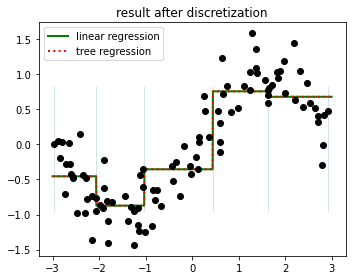

In [17]:
# 箱数减少为 5
enc = KBinsDiscretizer(n_bins=5,encode="onehot")
X_binned = enc.fit_transform(X)
line_binned = enc.transform(line)

fig, ax2 = plt.subplots(1, figsize=(5, 4))

LinearR_ = LR().fit(X_binned, y)
print(LinearR_.score(line_binned, np.sin(line)))
TreeR_ = DecisionTreeRegressor(random_state=0).fit(X_binned, y)

ax2.plot(line
         ,LinearR_.predict(line_binned)
         ,linewidth=2
         ,color="green"
         ,linestyle="-"
         ,label="linear regression"
        )
ax2.plot(line
         ,TreeR_.predict(line_binned)
         ,linewidth=2
         ,color="red"
         ,linestyle=":"
         ,label="tree regression"
        )

# 绘制和箱宽一致的竖线
ax2.vlines(enc.bin_edges_[0]
            ,*plt.gca().get_ylim() # y 的上限和下限
            ,linewidth=1
            ,alpha=0.2
           )

ax2.plot(X[:, 0], y, "o", c="k")

ax2.legend(loc="best")
ax2.set_title("result after discretization")
plt.tight_layout()
plt.show()

## 交叉验证选箱数

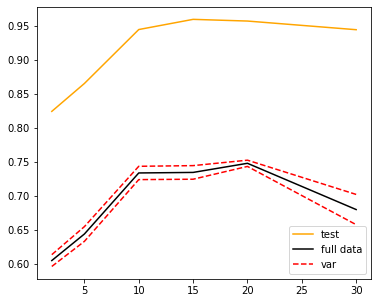

In [18]:
pred, score, var = [], [], []
binsrange = [2, 5, 10, 15, 20, 30]

for i in binsrange:
    # 实例化分箱类
    enc = KBinsDiscretizer(n_bins=i, encode="onehot")
    # 转换数据
    X_binned = enc.fit_transform(X)
    line_binned = enc.transform(line)
    # 建模
    LinearR_ = LR()
    cvresult = cross_val_score(LinearR_, X_binned, y, cv=5)
    score.append(cvresult.mean())
    var.append(cvresult.var())
    pred.append(LinearR_.fit(X_binned, y).score(line_binned, np.sin(line)))
    
plt.figure(figsize=(6, 5))
plt.plot(binsrange, pred, c="orange", label="test") # 测试数据
plt.plot(binsrange, score, c="k", label="full data") # 全数据上交叉验证结果均值
# 围绕在均值两边的方差
plt.plot(binsrange, score + np.array(var) * 0.5, c="red", linestyle="--", label="var") 
plt.plot(binsrange, score - np.array(var) * 0.5, c="red", linestyle="--")
plt.legend()
plt.show()

# 多项式回归

## 原始数据一维

In [19]:
X1 = np.arange(1, 4).reshape(-1, 1)
X1

array([[1],
       [2],
       [3]])

In [20]:
# 二次多项式
poly = PolynomialFeatures(degree=2)

In [21]:
X1_ = poly.fit_transform(X1)
print(X1_)

[[1. 1. 1.]
 [1. 2. 4.]
 [1. 3. 9.]]


In [22]:
# 三次多项式
poly = PolynomialFeatures(degree=3)

In [23]:
X1_3 = poly.fit_transform(X1)
print(X1_3)

[[ 1.  1.  1.  1.]
 [ 1.  2.  4.  8.]
 [ 1.  3.  9. 27.]]


In [24]:
PolynomialFeatures(degree=3, include_bias=False).fit_transform(X1)

array([[ 1.,  1.,  1.],
       [ 2.,  4.,  8.],
       [ 3.,  9., 27.]])

In [25]:
xxx = PolynomialFeatures(degree=3).fit_transform(X1)
xxx.shape

(3, 4)

In [26]:
rnd = np.random.RandomState(42) 
y = rnd.randn(3)
y

array([ 0.49671415, -0.1382643 ,  0.64768854])

## 升维后的空间做线性回归

In [27]:
LR().fit(xxx, y).coef_

array([ 3.10862447e-15, -3.51045297e-01, -6.06987134e-01,  2.19575463e-01])

In [28]:
LR().fit(xxx, y).intercept_

1.2351711202036884

In [29]:
LR(fit_intercept=False).fit(xxx, y).coef_

array([ 1.00596411,  0.06916756, -0.83619415,  0.25777663])

In [30]:
LR(fit_intercept=False).fit(xxx, y).intercept_

0.0

## 二维特征的情况

In [31]:
X2 = np.arange(6).reshape(3, 2)
X2

array([[0, 1],
       [2, 3],
       [4, 5]])

In [32]:
PolynomialFeatures(degree=2).fit_transform(X2)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [33]:
# 只生成交互项
PolynomialFeatures(degree=2, interaction_only=True).fit_transform(X2)

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

# 多项式回归处理非线性问题

In [34]:
np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)
y = np.sin(X) + rnd.normal(size=len(X)) / 3

In [35]:
X = X.reshape(-1, 1)

In [36]:
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

## 线性回归

In [37]:
LinearR = LR().fit(X, y)

In [38]:
LinearR.score(X, y)

0.6116049215467445

In [39]:
LinearR.score(line, np.sin(line))

0.6826835831058071

## 5 次多项式拟合

In [40]:
d = 5

poly = PolynomialFeatures(degree=5)
X_ = poly.fit_transform(X)
line_ = poly.fit_transform(line)

In [41]:
LinearR_ = LR().fit(X_, y)

In [42]:
LinearR_.score(X_, y)

0.8577085541714713

In [43]:
LinearR_.score(line_, np.sin(line))

0.9881634624332646

## 可视化

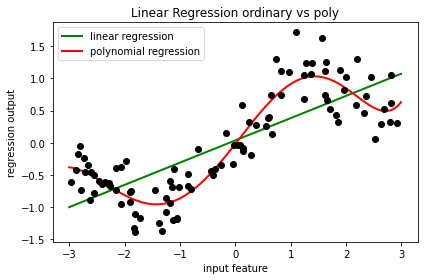

In [44]:
d = 6

poly = PolynomialFeatures(degree=d)
X_ = poly.fit_transform(X)
line_ = poly.fit_transform(line)
LinearR_ = LR().fit(X_, y)

fig, ax1 = plt.subplots(1)

ax1.plot(line, LinearR.predict(line), linewidth=2, color="green", label="linear regression")
ax1.plot(line, LinearR_.predict(line_), linewidth=2, color="red", label="polynomial regression")

ax1.plot(X[:, 0], y, "o", c="k")

ax1.legend(loc="best")
ax1.set_ylabel("regression output")
ax1.set_xlabel("input feature")
ax1.set_title("Linear Regression ordinary vs poly")

plt.tight_layout()
plt.show()

In [45]:
## 多项式回归的可解释性

In [46]:
X = np.arange(9).reshape(3, 3)
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [47]:
poly = PolynomialFeatures(degree=5).fit(X)

In [48]:
print(poly.get_feature_names())

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2', 'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3', 'x0^4', 'x0^3 x1', 'x0^3 x2', 'x0^2 x1^2', 'x0^2 x1 x2', 'x0^2 x2^2', 'x0 x1^3', 'x0 x1^2 x2', 'x0 x1 x2^2', 'x0 x2^3', 'x1^4', 'x1^3 x2', 'x1^2 x2^2', 'x1 x2^3', 'x2^4', 'x0^5', 'x0^4 x1', 'x0^4 x2', 'x0^3 x1^2', 'x0^3 x1 x2', 'x0^3 x2^2', 'x0^2 x1^3', 'x0^2 x1^2 x2', 'x0^2 x1 x2^2', 'x0^2 x2^3', 'x0 x1^4', 'x0 x1^3 x2', 'x0 x1^2 x2^2', 'x0 x1 x2^3', 'x0 x2^4', 'x1^5', 'x1^4 x2', 'x1^3 x2^2', 'x1^2 x2^3', 'x1 x2^4', 'x2^5']


# 数据-加利福尼亚房屋价值

In [49]:
from sklearn.datasets import fetch_california_housing as fsh

housevalue = fsh()
X = pd.DataFrame(housevalue.data)
y = housevalue.target

In [50]:
housevalue.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [51]:
X.columns = ["住户收入中位数","房屋使用年代中位数","平均房间数目"
             ,"平均卧室数目","街区人口","平均入住率","街区的纬度","街区的经度"]
X.columns

Index(['住户收入中位数', '房屋使用年代中位数', '平均房间数目', '平均卧室数目', '街区人口', '平均入住率', '街区的纬度',
       '街区的经度'],
      dtype='object')

In [52]:
X.head()

,住户收入中位数,房屋使用年代中位数,平均房间数目,平均卧室数目,街区人口,平均入住率,街区的纬度,街区的经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## 多项式回归建模

In [53]:
poly = PolynomialFeatures(degree=2).fit(X, y)

In [54]:
poly.get_feature_names(X.columns)

['1',
 '住户收入中位数',
 '房屋使用年代中位数',
 '平均房间数目',
 '平均卧室数目',
 '街区人口',
 '平均入住率',
 '街区的纬度',
 '街区的经度',
 '住户收入中位数^2',
 '住户收入中位数 房屋使用年代中位数',
 '住户收入中位数 平均房间数目',
 '住户收入中位数 平均卧室数目',
 '住户收入中位数 街区人口',
 '住户收入中位数 平均入住率',
 '住户收入中位数 街区的纬度',
 '住户收入中位数 街区的经度',
 '房屋使用年代中位数^2',
 '房屋使用年代中位数 平均房间数目',
 '房屋使用年代中位数 平均卧室数目',
 '房屋使用年代中位数 街区人口',
 '房屋使用年代中位数 平均入住率',
 '房屋使用年代中位数 街区的纬度',
 '房屋使用年代中位数 街区的经度',
 '平均房间数目^2',
 '平均房间数目 平均卧室数目',
 '平均房间数目 街区人口',
 '平均房间数目 平均入住率',
 '平均房间数目 街区的纬度',
 '平均房间数目 街区的经度',
 '平均卧室数目^2',
 '平均卧室数目 街区人口',
 '平均卧室数目 平均入住率',
 '平均卧室数目 街区的纬度',
 '平均卧室数目 街区的经度',
 '街区人口^2',
 '街区人口 平均入住率',
 '街区人口 街区的纬度',
 '街区人口 街区的经度',
 '平均入住率^2',
 '平均入住率 街区的纬度',
 '平均入住率 街区的经度',
 '街区的纬度^2',
 '街区的纬度 街区的经度',
 '街区的经度^2']

In [55]:
X_ = poly.transform(X)

In [56]:
reg = LR().fit(X_, y)

coef = reg.coef_

[*zip(poly.get_feature_names(X.columns), reg.coef_)]

[('1', 5.91955490391196e-08),
 ('住户收入中位数', -11.243025331812477),
 ('房屋使用年代中位数', -0.8488985486598638),
 ('平均房间数目', 6.4410590474305245),
 ('平均卧室数目', -31.591329075514484),
 ('街区人口', 0.00040609052319174905),
 ('平均入住率', 1.0038623331888172),
 ('街区的纬度', 8.705681906277963),
 ('街区的经度', 5.880632747708473),
 ('住户收入中位数^2', -0.031308128932015324),
 ('住户收入中位数 房屋使用年代中位数', 0.0018599475753805967),
 ('住户收入中位数 平均房间数目', 0.04330204746002773),
 ('住户收入中位数 平均卧室数目', -0.18614228106446193),
 ('住户收入中位数 街区人口', 5.728314621293758e-05),
 ('住户收入中位数 平均入住率', -0.002590194646868784),
 ('住户收入中位数 街区的纬度', -0.15250571489459583),
 ('住户收入中位数 街区的经度', -0.14424294139812083),
 ('房屋使用年代中位数^2', 0.00021172531993121722),
 ('房屋使用年代中位数 平均房间数目', -0.001262190027965632),
 ('房屋使用年代中位数 平均卧室数目', 0.010611505323046624),
 ('房屋使用年代中位数 街区人口', 2.8188513449406427e-06),
 ('房屋使用年代中位数 平均入住率', -0.0018171695149762587),
 ('房屋使用年代中位数 街区的纬度', -0.01006903722502449),
 ('房屋使用年代中位数 街区的经度', -0.009999501746049888),
 ('平均房间数目^2', 0.007269477625806538),
 ('平均房间数目 平均

In [57]:
coeff = pd.DataFrame([poly.get_feature_names(X.columns), reg.coef_]).T
coeff.columns = ["feature", "coef"]

coeff.sort_values(by="coef")

,feature,coef
4,平均卧室数目,-31.5913
1,住户收入中位数,-11.243
2,房屋使用年代中位数,-0.848899
33,平均卧室数目 街区的纬度,-0.437043
34,平均卧室数目 街区的经度,-0.404151
12,住户收入中位数 平均卧室数目,-0.186142
15,住户收入中位数 街区的纬度,-0.152506
16,住户收入中位数 街区的经度,-0.144243
32,平均卧室数目 平均入住率,-0.0871911
25,平均房间数目 平均卧室数目,-0.0689064


## 用多项式回归对模型表现的提升

In [58]:
poly = PolynomialFeatures(degree=4).fit(X, y)
X_ = poly.transform(X)

In [59]:
reg = LR().fit(X, y)
reg.score(X, y)

0.606232685199805

In [60]:
reg_ = LR().fit(X_, y)
reg_.score(X_, y)

0.7451589627095598

In [61]:
coeff = pd.DataFrame([poly.get_feature_names(X.columns), reg_.coef_]).T
coeff.columns = ["feature", "coef"]

coeff.sort_values(by="coef")

,feature,coef
491,街区的纬度^3 街区的经度,-0.0107783
490,街区的纬度^4,-0.00871983
492,街区的纬度^2 街区的经度^2,-0.00499106
377,平均房间数目^2 平均卧室数目 平均入住率,-0.00377483
436,平均卧室数目^2 平均入住率 街区的经度,-0.00257259
...,...,...
38,街区人口 街区的经度,0.00210401
183,住户收入中位数^2 平均房间数目 平均入住率,0.00211853
319,房屋使用年代中位数 平均房间数目 平均卧室数目^2,0.00248203
168,住户收入中位数^3 平均卧室数目,0.00281903


## 使用其它模型

In [62]:
from sklearn.ensemble import RandomForestRegressor as RFR

rfr = RFR(n_estimators=100).fit(X, y)
rfr.score(X, y)

0.9741535248692385